# Recurrent Neural Networks - IMDB Movie Reviews

Based on https://www.tensorflow.org/tutorials/keras/text_classification and https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/.
This notebook loads labeled IMDB review data with the aim to classify sentiment (positive/negative). The original data set is available from http://ai.stanford.edu/~amaas/data/sentiment/.

## Preparations

In [10]:
import os

## adapt this directories to your needs
base_dir = '../../'
data_dir_base = os.path.join(base_dir, "DataSets")
# data_dir_base = r"D:\Users\Julian\OneDrive - FH OOe\Kurse\3. Semester\NDLeIL\Datasets"
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(data_dir_base, 'IMDB_processed')

In [11]:
!sudo apt update -y
!sudo apt install libgl1-mesa-glx -y
!pip install git+https://github.com/UBod/pyMLaux.git

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
5 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
  Cloning https://github.com/UBod/pyMLaux.git to /tmp/pip-req-build-3immdtnl
  Running command git clone --filter=blob:none --quiet https://github.com/UBod/pyMLaux.git /tmp/pip-req-build-3immdtnl
  Resolved https://github.com/UBod/pyMLaux.git to commit 58c39ee9

In [12]:
import os
import re
import string

import numpy as np
import pandas as pd
import tensorflow as tf

from pyMLaux import plot_history, evaluate_classification_result

In [13]:
train_data_dir = os.path.join(data_dir, 'aclImdb/train')
test_data_dir = os.path.join(data_dir, 'aclImdb/test')

## Configure Data Sources

In [14]:
batch_size = 64

train_data_raw = tf.keras.utils.text_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=4232)

validation_data_raw = tf.keras.utils.text_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=4232)

test_data_raw = tf.keras.utils.text_dataset_from_directory(
    test_data_dir,
    batch_size=batch_size,
    shuffle=False)

Found 25000 files belonging to 2 classes.
Using 21250 files for training.
Found 25000 files belonging to 2 classes.
Using 3750 files for validation.
Found 25000 files belonging to 2 classes.


In [15]:
for text_batch, label_batch in train_data_raw:
    for i in range(3):
        print('Review:\n', str(text_batch.numpy()[i]),
              '\nLabel:',  train_data_raw.class_names[label_batch.numpy()[i]], '\n')
    break

Review:
 b"I usually enjoy Loretta Young's early movies: her acting back then was light and breezy, and she sure knew how to wear clothes. But this one is just a loser from the word go except for a funny supporting turn by Glenda Farrell. Young is a hatcheck girl who talks her writer-husband (Paul Lukas) into becoming a championship bridge player. It's not the most cinematic of games, and the long, talky middle part in which their marriage falls apart just about kills the film.<br /><br />There's one interesting bit though. As Lukas and Ferdinand Gottschalk start their climactic game, a series of quick shots show airplanes, trains, football games, even a diver in mid-air, freezing in anticipation of the event. It's the earliest use of a freeze frame I've seen in an American film. Wish the rest of it were that inventive-and funny." 
Label: neg 

Review:
 b'Its too bad a lot of people didn\'t understand this and the next episode.<br /><br />But don\'t worry! ill explain it too you :)<br 

In [16]:
## function for removing HTML tags like <br />
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [17]:
max_features = 10000 ## size of vocabulary
sequence_length = 250 ## standardized length of text sequences

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [18]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_data_raw.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-12-18 23:09:24.515623: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
print(' 123 -> ', vectorize_layer.get_vocabulary()[123])
print('4232 -> ', vectorize_layer.get_vocabulary()[4232])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

 123 ->  end
4232 ->  lyrics
Vocabulary size: 10000


In [20]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [21]:
train_data = train_data_raw.map(vectorize_text)
validation_data = validation_data_raw.map(vectorize_text)
test_data = test_data_raw.map(vectorize_text)

## Create Model

In [41]:
embedding_vector_length = 32
epochs = 20

### Changes Compared to model from Lecture:
* Add DropoutLayers with (0.4) after Embedding and LSTM Layer to reduce overfitting
* Add kernel regularization to LSTM Layer

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1, )),
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1, 32)          │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,897 (1.32 MB)

 Trainable params: 344,897 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [44]:
model_path_base = os.path.join(base_dir, 'Models/IMDB_model1')
filepath = os.path.join(model_path_base, 'IMDB_model1_{epoch:02d}-{val_accuracy:.4f}.keras')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_data, validation_data=validation_data, epochs=epochs,
                    batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/20
331/333 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5004 - loss: 0.8893
Epoch 1: val_accuracy improved from -inf to 0.51840, saving model to ../../Models/IMDB_model1/IMDB_model1_01-0.5184.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5004 - loss: 0.8882 - val_accuracy: 0.5184 - val_loss: 0.6932
Epoch 2/20
330/333 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5033 - loss: 0.6934
Epoch 2: val_accuracy improved from 0.51840 to 0.52453, saving model to ../../Models/IMDB_model1/IMDB_model1_02-0.5245.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5033 - loss: 0.6934 - val_accuracy: 0.5245 - val_loss: 0.6932
Epoch 3/20
328/333 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5116 - loss: 0.6934
Epoch 3: val_accuracy did not improve from 0.52453
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5116 - loss: 0.6934 - val_accuracy: 0.4920 - val_loss: 0.6953
Epoch 4/20
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5177 - loss: 0.6935


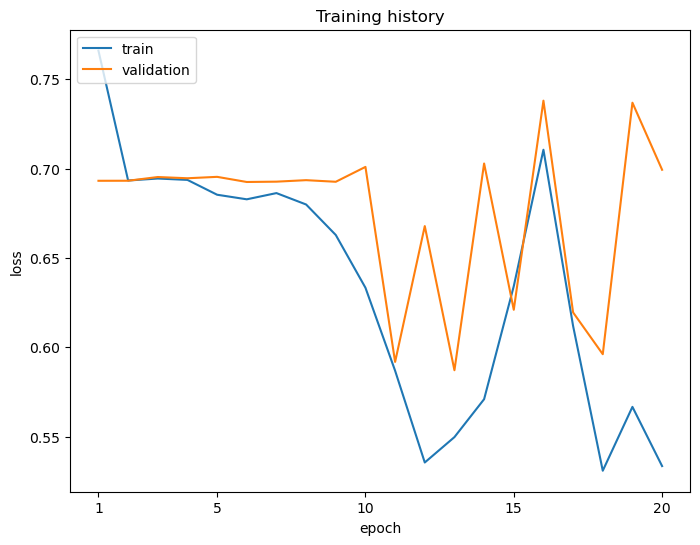

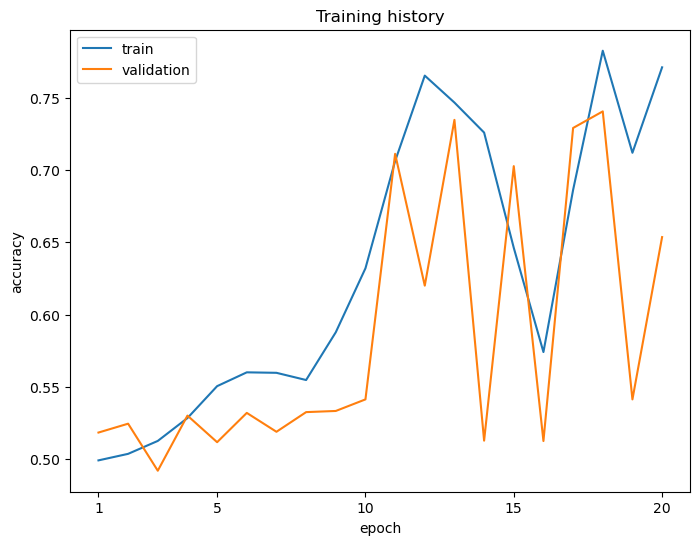

In [45]:
plot_history(history)

## Evaluate on Test Data

In [47]:
model = tf.keras.models.load_model(os.path.join(base_dir, "Models/IMDB_model1/IMDB_model1_18-0.7405.keras"))

In [48]:
pred = model.predict(test_data)

 25/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [49]:
test_y = np.concatenate([labels for _, labels in test_data], axis=0)

In [50]:
evaluate_classification_result(test_y, pred, classes=test_data_raw.class_names)

Confusion matrix (rows -> true, columns -> predicted):

      neg    pos
neg  8409   4091
pos  2294  10206


Class neg:
    Sensitivity (TPR):  67.272% (8409 of 12500)
    Specificity (TNR):  81.648% (10206 of 12500)
    Precision:          78.567% (8409 of 10703)
    Neg. pred. value:   71.386% (10206 of 14297)
Class pos:
    Sensitivity (TPR):  81.648% (10206 of 12500)
    Specificity (TNR):  67.272% (8409 of 12500)
    Precision:          71.386% (10206 of 14297)
    Neg. pred. value:   78.567% (8409 of 10703)

Overall accuracy:   74.460% (18615 of 25000)
Balanced accuracy:  74.460%


## Evaluate on Custom Test Data

In [51]:
my_text = ['this is probably the worst movie i have seen in my entire life it really sucks in the most obnoxious way',
           'if i had a dollar for each error in this movie i would be rich',
           'great movie wow i really really liked it',
           'complete trash show wasted money if you ask me',
           'this was one of the worst movies i have ever seen',
           'great movie would highly recommend',
           'it was an incredible experience and i would watch it again without second thought',
           'film bad',
           'it was more or less good']

In [52]:
my_test_data =  np.array([vectorize_layer(text) for text in my_text])
my_test_data

array([[  10,    7,  235, ...,    0,    0,    0],
       [  44,   11,   66, ...,    0,    0,    0],
       [  84,   17, 1340, ...,    0,    0,    0],
       ...,
       [   9,   13,   33, ...,    0,    0,    0],
       [  19,   81,    0, ...,    0,    0,    0],
       [   9,   13,   50, ...,    0,    0,    0]])

In [53]:
pred = model.predict(my_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [54]:
pd.DataFrame({'review': my_text, 'pred': pred.reshape(-1)})

,review,pred
0,this is probably the worst movie i have seen i...,0.207000
1,if i had a dollar for each error in this movie...,0.207000
2,great movie wow i really really liked it,0.695083
3,complete trash show wasted money if you ask me,0.207000
4,this was one of the worst movies i have ever seen,0.207000
5,great movie would highly recommend,0.695083
6,it was an incredible experience and i would wa...,0.695083
7,film bad,0.207000
8,it was more or less good,0.207000


In [1]:
!jupyter nbconvert --to html Ex5_Grimm_model1.ipynb

[NbConvertApp] Converting notebook Ex5_Grimm_model1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 465148 bytes to Ex5_Grimm_model1.html
